# Import Libraries


In [196]:
import pandas as pd
import numpy as np
np.object = object 
np.int = int 
np.float = float 
np.bool = bool 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, precision_score, recall_score
import os
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
# from surprise import SVD, Dataset, Reader
# from surprise.model_selection import cross_validate
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dot
import networkx as nx
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from surprise import Reader, Dataset

# Import Dataset

In [223]:
df = pd.read_csv(r'C:\Users\rahul\Desktop\Work\New_Projects\IT_Software_Development\Amazon_Sales_Data_RecSys\amazon.csv')
df_input = df.copy()
df.head(3)

product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   

  actual_price discount_percentage rating rating_count  \
0       ₹1,099                 64%    4.2       24,269   
1         ₹349                 43%    4.0       43,994   
2       ₹1,899                 90%    3.9        7,928   

                                       about_product  \
0  High Compatibility : Compatible With iPhone 12...   
1  Compatible with all Type C enabled devices, be...   
2  【 Fast Charger& Data Sync】-With built-in safet...   

                                             user_id  \
0  AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...   
1  AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...   
2  AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...   

                                           user_name  \
0  Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...   
1  ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...   
2  Kunal,Himanshu,viswanath,sai niharka,saqib mal...   

                                           review_id  \
0  R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...   
1  RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...   
2  R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...   

                                        review_title  \
0  Satisfied,Charging is really fast,Value for mo...   
1  A Good Braided Cable for Your Type C Device,Go...   
2  Good speed for earlier versions,Good Product,W...   

                                      review_content  \
0  Looks durable Charging is fine tooNo complains...   
1  I ordered this cable to connect my phone to An...   
2  Not quite durable and sturdy,https://m.media-a...   

                                            img_link  \
0  https://m.media-amazon.com/images/W/WEBP_40237...   
1  https://m.media-amazon.com/images/W/WEBP_40237...   
2  https://m.media-amazon.com/images/W/WEBP_40237...   

                                        product_link  
0  https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...  
1  https://www.amazon.in/Ambrane-Unbreakable-Char...  
2  https://www.amazon.in/Sounce-iPhone-Charging-C...

# Data Cleaning, Preporcessing

In [198]:
df['rating'] = df['rating'].str.replace('|', '3.9').astype('float64')
df['rating_count'] = df['rating_count'].str.replace(',', '').astype('float64')
df['rating_count'] = df.rating_count.fillna(value=df['rating_count'].median())

C:\Users\rahul\AppData\Local\Temp\ipykernel_19996\1165948936.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['rating'] = df['rating'].str.replace('|', '3.9').astype('float64')


In [199]:
df.isnull().sum().sort_values(ascending = False)

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [200]:
def safe_get(data, key, default=None):
    """
    Safely retrieves a value from a dictionary or DataFrame by key.
    If the key does not exist, returns a default value.
    """
    if key in data:
        return data[key]
    else:
        print(f"Warning: Key {key} not found.")
        return default


In [201]:
relevant_columns = ['product_id', 'product_name', 'category', 'discounted_price', 'discount_percentage',
                    'actual_price', 'rating', 'rating_count', 'user_id', 
                    'review_id', 'review_content', 'img_link']
data = df[relevant_columns].copy()
data_plt = df[relevant_columns].copy()

In [202]:
df['discounted_price'] = df['discounted_price'].str.replace("₹",'')
df['discounted_price'] = df['discounted_price'].str.replace(",",'')
df['discounted_price'] = df['discounted_price'].astype('float64')

df['actual_price'] = df['actual_price'].str.replace("₹",'')
df['actual_price'] = df['actual_price'].str.replace(",",'')
df['actual_price'] = df['actual_price'].astype('float64')

In [204]:
data.fillna("", inplace=True)
data_plt.fillna("", inplace=True)
print("Cleaned Dataset:")
print(data.head())

Cleaned Dataset:
   product_id                                       product_name  \
0  B07JW9H4J1  Wayona Nylon Braided USB to Lightning Fast Cha...   
1  B098NS6PVG  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...   
2  B096MSW6CT  Sounce Fast Phone Charging Cable & Data Sync U...   
3  B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...   
4  B08CF3B7N1  Portronics Konnect L 1.2M Fast Charging 3A 8 P...   

                                            category discounted_price  \
0  Computers&Accessories|Accessories&Peripherals|...             ₹399   
1  Computers&Accessories|Accessories&Peripherals|...             ₹199   
2  Computers&Accessories|Accessories&Peripherals|...             ₹199   
3  Computers&Accessories|Accessories&Peripherals|...             ₹329   
4  Computers&Accessories|Accessories&Peripherals|...             ₹154   

  discount_percentage actual_price  rating  rating_count  \
0                 64%       ₹1,099     4.2       24269.0   
1              

In [205]:
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(data['review_content'])

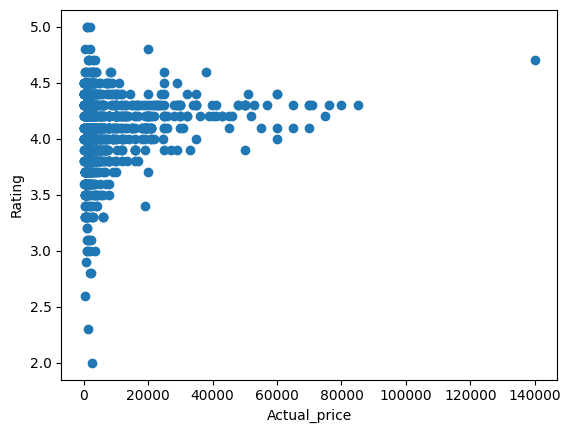

In [207]:
plt.scatter(df['actual_price'], df['rating'])
plt.xlabel('Actual_price')
plt.ylabel('Rating')
plt.show()

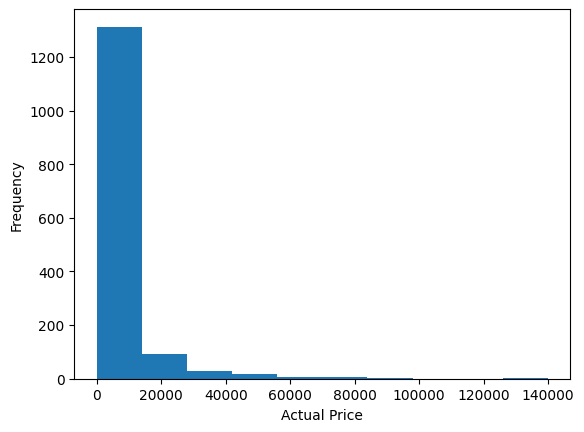

In [208]:
plt.hist(df['actual_price'])
plt.xlabel('Actual Price')
plt.ylabel('Frequency')
plt.show()

In [209]:
le_product_id = LabelEncoder()
le_category = LabelEncoder()
le_review_id = LabelEncoder()
le_review_content = LabelEncoder()
le_product_name = LabelEncoder()
le_user_name = LabelEncoder()
le_about_product = LabelEncoder()
le_user_id = LabelEncoder()
le_review_title = LabelEncoder()
le_img_link = LabelEncoder()
le_product_link = LabelEncoder()


df['product_id'] = le_product_id.fit_transform(df['product_id'])
df['category'] = le_category.fit_transform(df['category'])
df['review_id'] = le_review_id.fit_transform(df['review_id'])
df['review_content'] = le_review_content.fit_transform(df['review_content'])
df['product_name'] = le_product_name.fit_transform(df['product_name'])
df['user_name'] = le_user_name.fit_transform(df['user_name'])
df['about_product'] = le_about_product.fit_transform(df['about_product'])
df['user_id'] = le_user_id.fit_transform(df['user_id'])
df['review_title'] = le_review_title.fit_transform(df['review_title'])
df['img_link'] = le_img_link.fit_transform(df['img_link'])
df['product_link'] = le_product_link.fit_transform(df['product_link'])

## Correlation Matrix

In [210]:
correlation_matrix = df.corr()
fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(correlation_matrix, annot=True)
plt.show()

                  product_id  product_name  category  discounted_price  \
product_id          1.000000      0.084089 -0.012565          0.206448   
product_name        0.084089      1.000000 -0.103778          0.090665   
category           -0.012565     -0.103778  1.000000          0.119365   
discounted_price    0.206448      0.090665  0.119365          1.000000   
actual_price        0.246733      0.078567  0.122451          0.961915   
rating             -0.149105     -0.035592 -0.109424          0.120386   
rating_count       -0.175530      0.092450 -0.098421         -0.027081   
about_product       0.041404      0.158263 -0.038753          0.052618   
user_id             0.065688     -0.024093  0.012707          0.041731   
user_name           0.016145      0.024598  0.037822         -0.063069   
review_id          -0.024282      0.013492  0.014015         -0.049757   
review_title        0.007650     -0.060594  0.004712         -0.020981   
review_content     -0.046273     -0.01

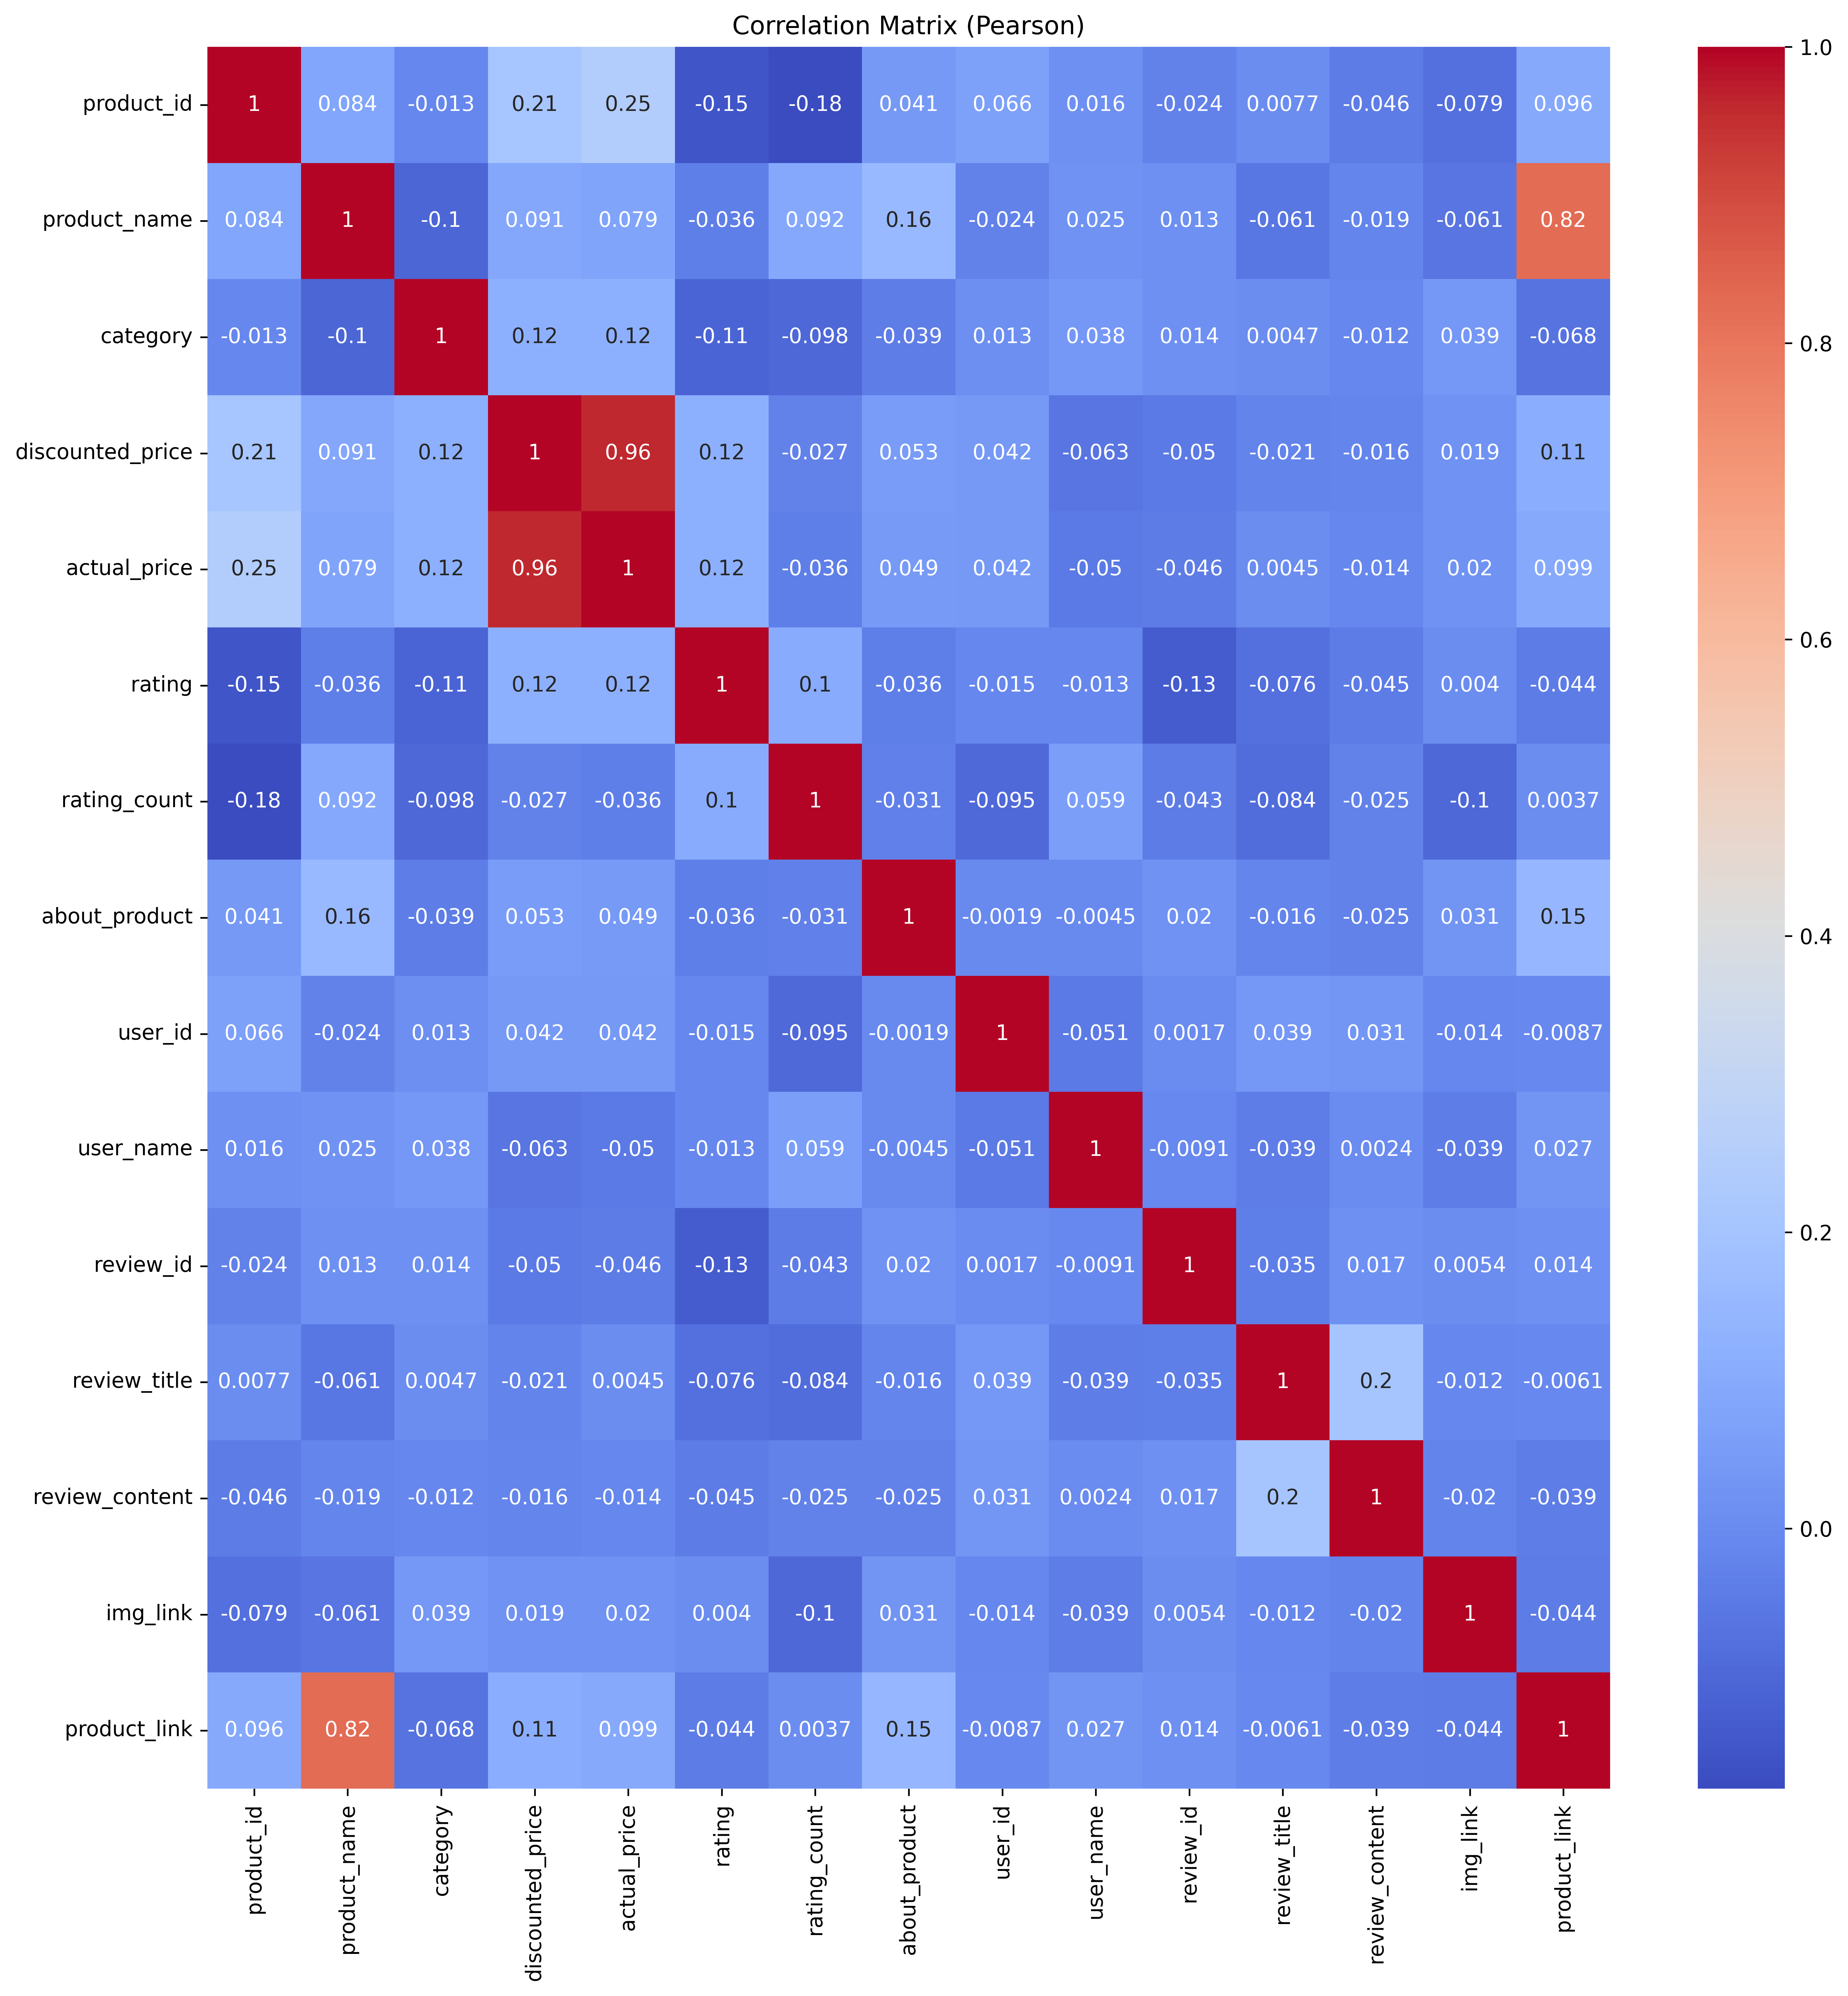

                  product_id  product_name  category  discounted_price  \
product_id          1.000000      0.083112 -0.013553          0.146237   
product_name        0.083112      1.000000 -0.106193          0.056597   
category           -0.013553     -0.106193  1.000000          0.360733   
discounted_price    0.146237      0.056597  0.360733          1.000000   
actual_price        0.269064      0.105719  0.277291          0.932787   
rating             -0.144268     -0.061395 -0.101758          0.079412   
rating_count       -0.406559      0.128565 -0.171893          0.122296   
about_product       0.041118      0.157675 -0.048319         -0.056144   
user_id             0.065228     -0.023810  0.015389          0.079048   
user_name           0.016859      0.024479  0.038735         -0.018599   
review_id          -0.024644      0.015269  0.016119         -0.048420   
review_title        0.007415     -0.060779  0.009407         -0.018665   
review_content     -0.045763     -0.01

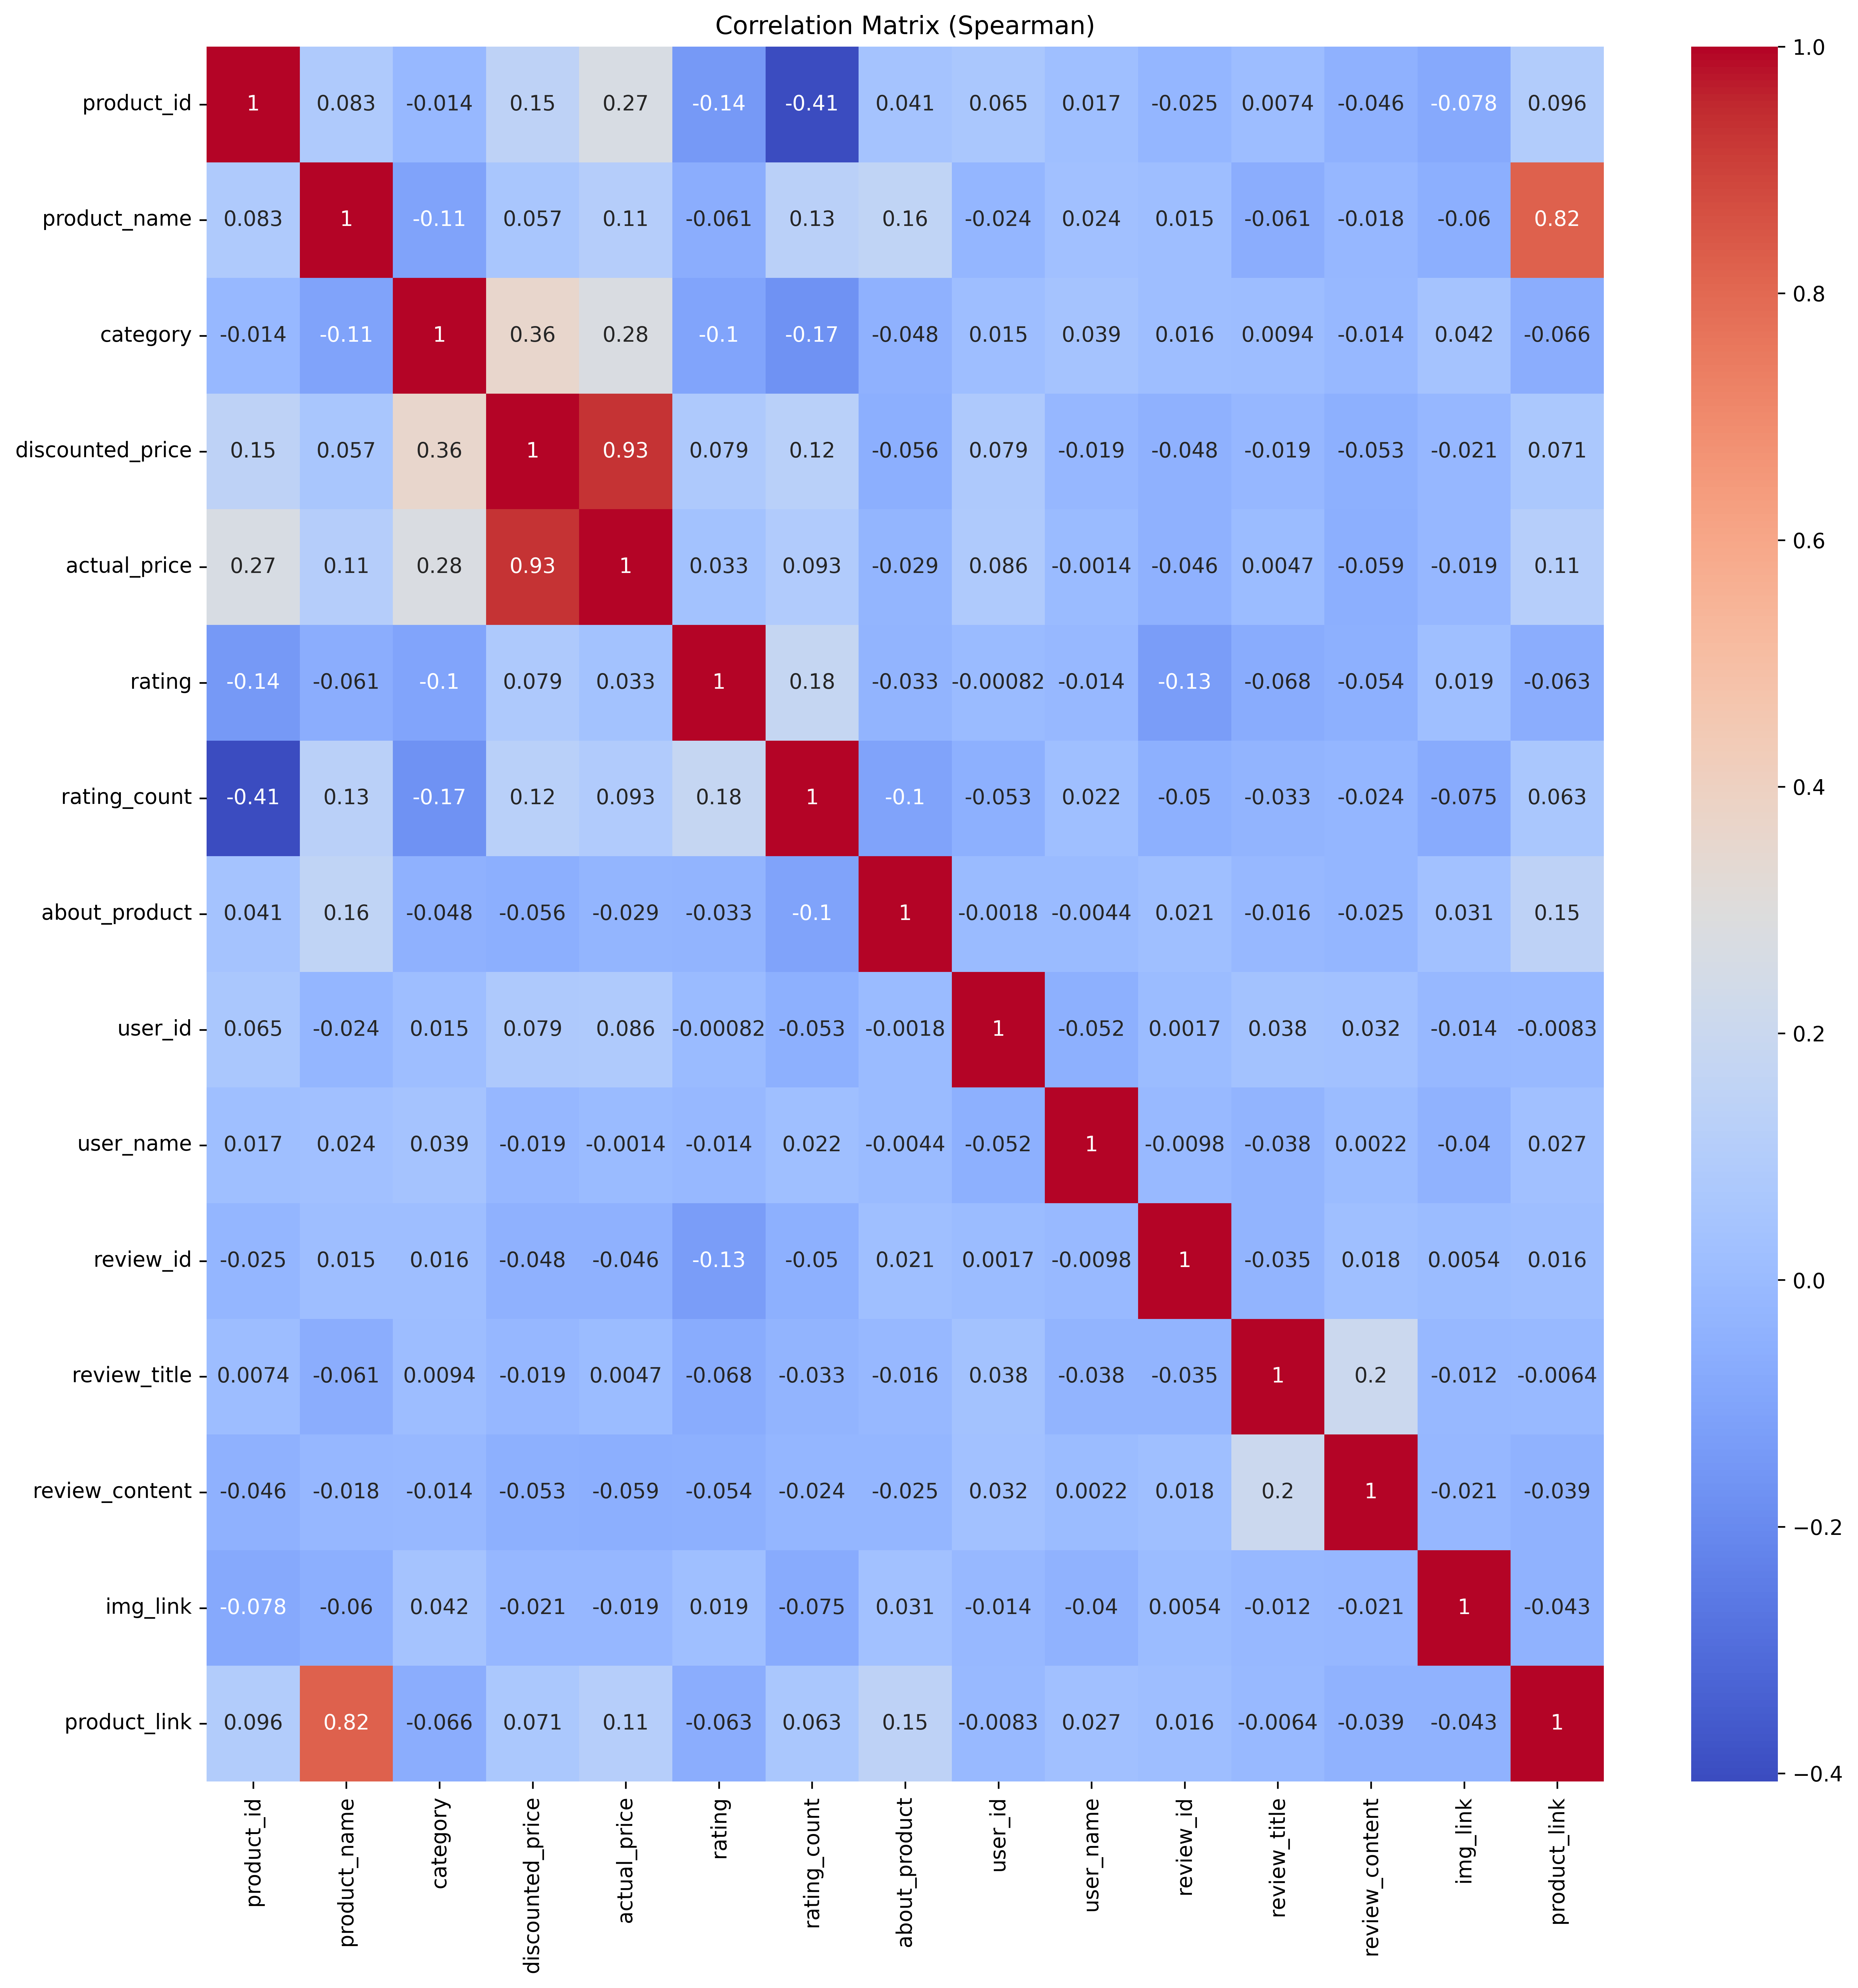

In [211]:
correlation_matrix = df.corr()

# Print the correlation matrix
print(correlation_matrix)

# Create a heatmap to visualize the correlations
fig = plt.figure(figsize=(15,15), dpi = 480)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Pearson)")
plt.show()

# Calculate Spearman correlation coefficients (for non-linear relationships)
spearman_correlation_matrix = df.corr(method="spearman")

# Print the Spearman correlation matrix
print(spearman_correlation_matrix)

# Create a heatmap to visualize the Spearman correlations
fig = plt.figure(figsize=(15,15), dpi = 480)
sns.heatmap(spearman_correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Spearman)")
plt.show()

## Plots

In [212]:
data_plt['discount_percentage'] = data_plt['discount_percentage'].str.rstrip('%').astype(float)

C:\Users\rahul\AppData\Local\Temp\ipykernel_19996\241222896.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_by_product.index, y=avg_rating_by_product.values, palette='tab10')


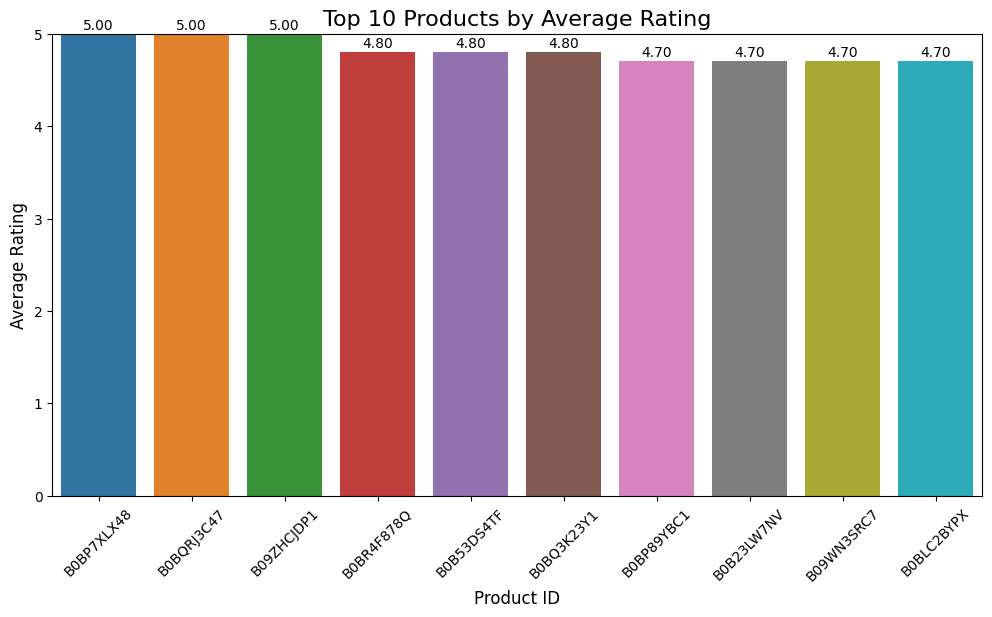

In [214]:
avg_rating_by_product = data_plt.groupby('product_id')['rating'].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rating_by_product.index, y=avg_rating_by_product.values, palette='tab10')
plt.title("Top 10 Products by Average Rating", fontsize=16)
plt.xlabel("Product ID", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.ylim(0, 5)  # Ratings range from 1 to 5
plt.xticks(rotation=45)

# Add value labels
for index, value in enumerate(avg_rating_by_product.values):
    plt.text(index, value + 0.05, f"{value:.2f}", ha='center', fontsize=10)

plt.show()

C:\Users\rahul\AppData\Local\Temp\ipykernel_19996\2511048725.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_rating_by_category.index, y=avg_rating_by_category.values, palette='tab10')


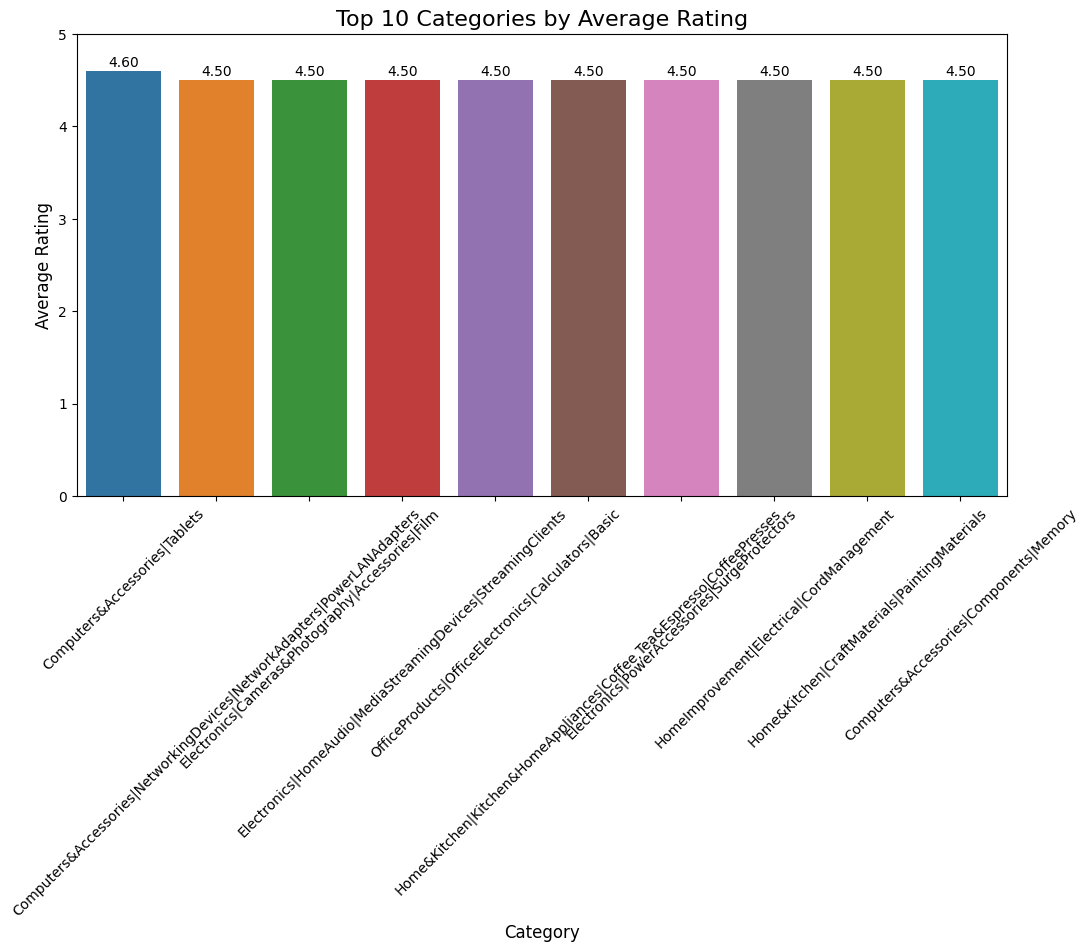

In [215]:
avg_rating_by_category = data_plt.groupby('category')['rating'].mean().sort_values(ascending=False).head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=avg_rating_by_category.index, y=avg_rating_by_category.values, palette='tab10')
plt.title("Top 10 Categories by Average Rating", fontsize=16)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Average Rating", fontsize=12)
plt.ylim(0, 5)  # Ratings range from 1 to 5
plt.xticks(rotation=45)

# Add value labels
for index, value in enumerate(avg_rating_by_category.values):
    plt.text(index, value + 0.05, f"{value:.2f}", ha='center', fontsize=10)

plt.show()

# Train-Test Split

In [216]:
# train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [217]:
# print("TF-IDF matrix shape:", tfidf_matrix.shape)

In [218]:
# data.head()

## 1) User-Based Collaborative Filtering

In [219]:
user_product_matrix = data.pivot_table(index='user_id', columns='product_id', values='rating', fill_value=0)
user_product_matrix = user_product_matrix.loc[:, user_product_matrix.columns.isin(data['product_id'])]

In [220]:
user_similarity = cosine_similarity(user_product_matrix)

In [225]:
def recommend_user_based(user_id, num_recommendations=5):
    if user_id not in df['user_id'].values:
        print(f"User ID {user_id} not found in dataset.")
        return []
    user_idx = user_product_matrix.index.get_loc(user_id)
    similar_users = np.argsort(user_similarity[user_idx])[::-1][1:]  # Exclude self
    recommended_products = {}

    for similar_user_idx in similar_users:
        similar_user = user_product_matrix.index[similar_user_idx]
        products = data[data['user_id'] == similar_user]['product_id']
        for product in products:
            if product not in recommended_products:
                recommended_products[product] = data[data['product_id'] == product][['product_name', 'rating','product_id', 'discounted_price', 'img_link']].iloc[0]

    return pd.DataFrame(list(recommended_products.values())).head(num_recommendations)



In [226]:
# Example usage
recommendations = recommend_user_based(df['user_id'][2])
print(recommendations)

                                                user_id  \
558   AHZWXUWE3RGLDH4JJUK3HT3VMBJA,AFWUWJMEO4IQEMHKM...   
1043  AFDP6MHD6SSBGTNIH6VX4FQDKNUQ,AGOYO7V7CGV5RA6ZA...   
135   AFCWL3MX7BP2ZUDD37MEAENZDQ2A,AGGFXDLCFZMTLJJDR...   
283   AFCWL3MX7BP2ZUDD37MEAENZDQ2A,AGGFXDLCFZMTLJJDR...   
1425  AFD544VTKFVTUBCBN3HKF2KO33TA,AFGRUPW5QB7WCNB6Q...   

                                           product_name  rating  product_id  \
558   MI REDMI 9i Sport (Carbon Black, 64 GB) (4 GB ...     4.3  B09HSKYMB3   
1043  KENT 16052 Elegant Electric Glass Kettle 1.8L ...     4.0  B07YR26BJ3   
135   LG 108 cm (43 inches) 4K Ultra HD Smart LED TV...     4.3  B0B3XY5YT4   
283   LG 139 cm (55 inches) 4K Ultra HD Smart LED TV...     4.3  B0B3XXSB1K   
1425      LACOPINE Mini Pocket Size Lint Roller (White)     3.9  B081RLM75M   

     discounted_price                                           img_link  
558            ₹7,915  https://m.media-amazon.com/images/I/31Hb9RGI+j...  
1043           ₹1,19

## 2) Item-Based Collaborative Filtering

In [227]:
item_similarity = cosine_similarity(user_product_matrix.T)

In [236]:
def recommend_item_based(product_id, num_recommendations=5):
    if product_id not in df['product_id'].values:
        print(f"Item ID {product_id} not found in dataset.")
        return []
    product_idx = user_product_matrix.columns.get_loc(product_id)
    similar_products = np.argsort(item_similarity[product_idx])[::-1][1:]  # Exclude self
    recommended_products = []

    for similar_product_idx in similar_products[:num_recommendations]:
        similar_product = user_product_matrix.columns[similar_product_idx]
        recommended_products.append(
            data[data['product_id'] == similar_product][['product_name', 'rating','product_id', 'discounted_price', 'img_link']].iloc[0]
        )

    return pd.DataFrame(recommended_products)



In [237]:
# Example usage
recommendations = recommend_item_based(df['product_id'][2])
print(recommendations)

                                           product_name  rating  product_id  \
1145  Swiffer Instant Electric Water Heater Faucet T...     4.8  B0BR4F878Q   
1099  Pigeon by Stovekraft Quartz Electric Kettle (1...     3.9  B07WGPBXY9   
450   iQOO Z6 Pro 5G by vivo (Legion Sky, 8GB RAM, 1...     4.3  B07WDK3ZS2   
435   iQOO Z6 Lite 5G by vivo (Mystic Night, 6GB RAM...     4.1  B07WDK3ZS6   
394   iQOO Neo 6 5G (Dark Nova, 8GB RAM, 128GB Stora...     4.4  B07WDKLDRX   

     discounted_price                                           img_link  
1145           ₹1,439  https://m.media-amazon.com/images/I/41+t2HWvwF...  
1099             ₹899  https://m.media-amazon.com/images/W/WEBP_40237...  
450           ₹20,999  https://m.media-amazon.com/images/I/41XtHlbmOH...  
435           ₹15,499  https://m.media-amazon.com/images/I/41Yylo75u7...  
394           ₹28,999  https://m.media-amazon.com/images/I/51DLLa8HNW...  


## 3) Content-Based Filtering

In [238]:
product_similarity = cosine_similarity(tfidf_matrix)

In [239]:
def recommend_content_based(product_name, num_recommendations=5):
    product_idx = data[data['product_name'] == product_name].index[0]
    similar_products = np.argsort(product_similarity[product_idx])[::-1][1:num_recommendations+1]
    
    recommended_products = []
    for idx in similar_products:
        recommended_products.append(data.iloc[idx][['product_name', 'product_id', 'rating', 'discounted_price', 'img_link']])

    return pd.DataFrame(recommended_products)



In [240]:
# Example usage
recommendations = recommend_content_based(df['product_name'][30])
print(recommendations)

                                          product_name  product_id  rating  \
802  AmazonBasics USB 2.0 - A-Male to A-Female Exte...  B00NH11PEY     4.5   
30   AmazonBasics USB 2.0 - A-Male to A-Female Exte...  B00NH11PEY     4.5   
294  AmazonBasics USB Type-C to Micro-B 2.0 Cable -...  B01LONQBDG     4.1   
795  Portronics MPORT 31 4 Ports USB Hub (USB A to ...  B09M8888DM     4.3   
377  Ambrane Unbreakable 60W / 3A Fast Charging 1.5...  B098NS6PVG     4.0   

    discounted_price                                           img_link  
802             ₹199  https://m.media-amazon.com/images/W/WEBP_40237...  
30              ₹199  https://m.media-amazon.com/images/W/WEBP_40237...  
294             ₹349  https://m.media-amazon.com/images/W/WEBP_40237...  
795             ₹499  https://m.media-amazon.com/images/W/WEBP_40237...  
377             ₹199  https://m.media-amazon.com/images/I/31zOsqQOAO...  


## 4) Hybrid Filtering

In [241]:
def hybrid_recommendation(user_id, product_name, num_recommendations=5):
    # User-based recommendations
    user_recommendations = recommend_user_based(user_id, num_recommendations=num_recommendations)
    
    # Content-based recommendations
    content_recommendations = recommend_content_based(product_name, num_recommendations=num_recommendations)
    
    # Combine both results
    hybrid_results = pd.concat([user_recommendations, content_recommendations]).drop_duplicates()
    return hybrid_results.head(num_recommendations)



In [242]:
# Example usage
hybrid_recommendations = hybrid_recommendation(df['user_id'][3], df['product_name'][30])
print(hybrid_recommendations)

                                                user_id  \
558   AHZWXUWE3RGLDH4JJUK3HT3VMBJA,AFWUWJMEO4IQEMHKM...   
1043  AFDP6MHD6SSBGTNIH6VX4FQDKNUQ,AGOYO7V7CGV5RA6ZA...   
135   AFCWL3MX7BP2ZUDD37MEAENZDQ2A,AGGFXDLCFZMTLJJDR...   
283   AFCWL3MX7BP2ZUDD37MEAENZDQ2A,AGGFXDLCFZMTLJJDR...   
1425  AFD544VTKFVTUBCBN3HKF2KO33TA,AFGRUPW5QB7WCNB6Q...   

                                           product_name  rating  product_id  \
558   MI REDMI 9i Sport (Carbon Black, 64 GB) (4 GB ...     4.3  B09HSKYMB3   
1043  KENT 16052 Elegant Electric Glass Kettle 1.8L ...     4.0  B07YR26BJ3   
135   LG 108 cm (43 inches) 4K Ultra HD Smart LED TV...     4.3  B0B3XY5YT4   
283   LG 139 cm (55 inches) 4K Ultra HD Smart LED TV...     4.3  B0B3XXSB1K   
1425      LACOPINE Mini Pocket Size Lint Roller (White)     3.9  B081RLM75M   

     discounted_price                                           img_link  
558            ₹7,915  https://m.media-amazon.com/images/I/31Hb9RGI+j...  
1043           ₹1,19

## 5) Popularity-Based Recommendation

In [243]:
def recommend_popularity_based(num_recommendations=5):
    popular_products = data.groupby('product_id').agg({
        'product_id' : 'first',
        'rating': 'mean', 
        'rating_count': 'sum', 
        'product_name': 'first', 
        'discounted_price': 'first', 
        'img_link': 'first'
    }).sort_values(by=['rating_count', 'rating'], ascending=False)
    
    return popular_products[['product_name', 'rating', 'discounted_price', 'img_link']].head(num_recommendations)



In [244]:
def recommend_popularity_based(product_id, num_recommendations=5):
    # Filter the data to find products in the same category as the input product_id
    product_category = data.loc[data['product_id'] == product_id, 'category'].values[0]
    
    # Filter the products belonging to the same category
    related_products = data[data['category'] == product_category]
    
    # Aggregate the data to get the popularity score (based on rating and rating count)
    popular_products = related_products.groupby('product_id').agg({
        'product_id' : 'first',
        'rating': 'mean', 
        'rating_count': 'sum', 
        'product_name': 'first', 
        'discounted_price': 'first', 
        'img_link': 'first'
    }).sort_values(by=['rating_count', 'rating'], ascending=False)
    
    # Exclude the input product_id from recommendations
    popular_products = popular_products[popular_products['product_id'] != product_id]
    
    return popular_products[['product_name', 'rating', 'discounted_price', 'img_link']].head(num_recommendations)

In [245]:
# Example usage
popular_recommendations = recommend_popularity_based(df['product_id'][2])
print(popular_recommendations)

                                                 product_name  rating  \
product_id                                                              
B08HDJ86NZ  boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...     4.2   
B00NH11KIK  AmazonBasics USB 2.0 Cable - A-Male to B-Male ...     4.5   
B0789LZTCJ  boAt Rugged v3 Extra Tough Unbreakable Braided...     4.2   
B07232M876  Amazonbasics Micro Usb Fast Charging Cable For...     4.2   
B07DC4RZPY  Amazon Basics USB A to Lightning MFi Certified...     4.1   

           discounted_price                                           img_link  
product_id                                                                      
B08HDJ86NZ             ₹329  https://m.media-amazon.com/images/I/41V5FtEWPk...  
B00NH11KIK             ₹209  https://m.media-amazon.com/images/I/4101vlzySz...  
B0789LZTCJ             ₹299  https://m.media-amazon.com/images/I/41SDfuK7L2...  
B07232M876             ₹199  https://m.media-amazon.com/images/W/WEBP_40237...  
B0

## 6) Graph-Based Recommendation

In [246]:
# Create a bipartite graph
B = nx.Graph()

In [247]:
# Add nodes with attributes
B.add_nodes_from(data['user_id'].unique(), bipartite=0)
B.add_nodes_from(data['product_id'].unique(), bipartite=1)


In [248]:
# Add edges with ratings
B.add_edges_from([(row['user_id'], row['product_id'], {'weight': row['rating']}) for _, row in data.iterrows()])

In [249]:
def recommend_graph_based(user_id, n_recommendations=5):
    # Compute personalized PageRank
    pr = nx.pagerank(B, personalization={user_id: 1})
    
    # Filter for products and sort by PageRank score
    recommended_products = sorted(
        [(item, score) for item, score in pr.items() if item in data['product_id'].unique()],
        key=lambda x: x[1],
        reverse=True
    )
    
    # Get top N recommendations
    top_products = [item for item, _ in recommended_products[:n_recommendations]]
    
    # Fetch product details
    product_details = data[data['product_id'].isin(top_products)]
    
    # Sort the product details to match the rank order
    product_details['score'] = product_details['product_id'].map(dict(recommended_products))
    product_details = product_details.sort_values(by='score', ascending=False)
    
    # Return the product details
    return product_details

In [250]:
recommendations = recommend_graph_based(df['user_id'][3])

C:\Users\rahul\AppData\Local\Temp\ipykernel_19996\2614995189.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_details['score'] = product_details['product_id'].map(dict(recommended_products))


In [251]:
print(recommendations[['product_id', 'product_name', 'actual_price', 'discounted_price', 'img_link']].to_string(index=False))

product_id                                                                                                                                                                                            product_name actual_price discounted_price                                                                                              img_link
B08HDJ86NZ boAt Deuce USB 300 2 in 1 Type-C & Micro USB Stress Resistant, Tangle-Free, Sturdy Cable with 3A Fast Charging & 480mbps Data Transmission, 10000+ Bends Lifespan and Extended 1.5m Length(Martian Red)         ₹699             ₹329                         https://m.media-amazon.com/images/I/41V5FtEWPkL._SX300_SY300_QL70_FMwebp_.jpg
B0789LZTCJ                                                                                                                        boAt Rugged v3 Extra Tough Unbreakable Braided Micro USB Cable 1.5 Meter (Black)         ₹799             ₹299                         https://m.media-amazon.com/images/I/41SDfuK7L2L._